In [1]:
#libraries
import torch
import models
import os
import yaml
import numpy as np
from PIL import Image
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
import math
from skimage.metrics import structural_similarity as ssim
import torch.nn as nn
from torchvision.transforms import Resize
import cv2



In [2]:
device=torch.device('cuda:0')
torch.cuda.device_count()

3

In [3]:
def psnr(pred, out, rgb_range=1):
    '''
    inp: patch_count * channels * H * W
    pred: patch_count * channels * H * W
    '''
    diff = (pred - out)/ rgb_range
    mse = torch.mean(torch.pow(diff, 2))

    return -10 * torch.log10(mse).item() 

In [4]:
# Setting up the Initial Parameters and Image Trasnform
""" 
For Full resolution: 
resize = True

For disparity map or the lower resolution experiments, just change resize = False
"""



dir = '/home/gpu/girish/results_clrimg_resized/_unet_basic_single_image_raw_'
output_test_images = dir + '/output_test'
amp = 100
split_ratio = 0
raw = True
monochrome= False
resize = False
param_resize = True
rsize = [384, 1248]
train =  False
stereo = False
crop = True
psnr_arr = []
ssim_arr = []

In [5]:
#model construction
model_path = os.path.join(dir, 'epoch-best-psnr.pth')
sv_file = torch.load(model_path, map_location=device)
model = models.make(sv_file['model'], load_sd=True).eval().cuda()
model = nn.DataParallel(model, device_ids=[1])

In [6]:
# The Required Preprocessing 
""" 
Hmm. This code can be mereged with the visualzie_train/test
"""
def image_transform(img, amp=False, raw=False, output=False, resize = False, stereo = False, crop = True, rsize = [512, 512]):
    # Here where we should be working 
    if raw and not stereo:
        """ 
        Experiment
        # """
        # # Loading the file 
        # arr = np.array(Image.open(img))
        # arr = torch.from_numpy(arr/255)
        # if output == False:
        #     raw_h, raw_w = arr.shape
        #     r = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     g1 = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     g2 = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     b = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     r = img[0::2, 0::2]  # r
        #     g1 = img[0::2, 1::2]  # gr
        #     g2 = img[1::2, 0::2]  # gb
        #     b = img[1::2, 1::2]  # b
        #     img_unpack = np.dstack((r, g1, g2, b)) 
        #     # print(img_unpack.shape, 'image unpack shape')
        #     if amp:
        #         img_unpack_amp = np.clip(img_unpack*amp,0,1)
        # else:
        #     img_unpack_amp = img
        # img_unpack_amp = np.transpose(img_unpack_amp , (2,0,1))        
        # # print(img_unpack_amp.shape, 'before resizing shape')
        # if resize:
        #     resizer = Resize([512,512])
        #     img_unpack_amp_resize = resizer(torch.from_numpy(img_unpack_amp))

        """ 
        The Original 
        """
        img = cv2.imread(img, -1)
        # print(img.dtype, 'gives the image datatype')
        # img = img / 255.0
        # Unpacking


        # Cropping
        if crop:
            img = img[:2048, :]
        # print(img.shape, 'should have cropped and 1024 x 4096')


        if output == False:

            raw_h, raw_w = img.shape
            r = np.zeros((raw_h // 2, raw_w // 2, 1))
            g1 = np.zeros((raw_h // 2, raw_w // 2, 1))
            g2 = np.zeros((raw_h // 2, raw_w // 2, 1))
            b = np.zeros((raw_h // 2, raw_w // 2, 1))
            r = img[0::2, 0::2]  # r
            g1 = img[0::2, 1::2]  # gr
            g2 = img[1::2, 0::2]  # gb
            b = img[1::2, 1::2]  # b
            img_arr = np.dstack((r, g1, g2, b)) 
            img = torch.from_numpy(img_arr / 255).permute(2, 0, 1).unsqueeze(0)
            # print(img_unpack.shape, 'image unpack shape')
            if amp:
                img_unpack_amp = (img*amp).clamp_(0,1)
        else:
            img = torch.from_numpy(img/255).permute(2, 0, 1).unsqueeze(0)
            img_unpack_amp = img
        # img_unpack_amp = np.transpose(img_unpack_amp , (2,0,1))        
        # print(img_unpack_amp.shape, 'before resizing shape')
        if resize:
            resizer = Resize(rsize)
            img_unpack_amp_resize = resizer(img_unpack_amp)
        else:
            img_unpack_amp_resize = img_unpack_amp
        # print(img_unpack_amp_resize.shape, 'After resizing')
    elif raw and stereo:
        # img now is a list and should contain both the file names. Do the modifications in the fetching file name code
        
        pass
    else:
        arr = np.array(Image.open(img))
        if len(arr.shape)==3:
            pass
        elif len(arr.shape)==2:
            arr = np.repeat(np.expand_dims(arr, axis=2), 3, axis=2)
    # arr = torch.from_numpy(arr/255)
    # if amp:
        # print(arr.shape, 'Shape in here')
        # amp = amp_module(arr, 0.5)
        # amp_arr = (arr*amp).clamp_(0,1)
        # arr = amp_arr
    # res, h, w, p_x, p_y = patchify_img(np.array(arr), patch_size=512)
    # arr = torch.from_numpy(res).permute(0, 3, 1, 2)
    # if amp:
        # return arr, h, w, p_x, p_y, amp, amp_arr
    # else:
        # return arr, h, w, p_x, p_y
    # print(img_unpack_amp_resize.shape, 'input to the model')
    # print(img_unpack_amp_resize.shape, 'Transformed Image shape from image_transformation function line 100')
    return img_unpack_amp_resize
    

In [ ]:
# #Load and processing the image - Train

# with open(os.path.join(dir, 'config.yaml'), 'r') as f:
#         config = yaml.load(f, Loader=yaml.FullLoader)
        
# if config['val_dataset']['dataset']['args'].get('root_path_inp') is not None:
#     test_dir = config['val_dataset']['dataset']['args']['root_path_inp']
#     out_dir = config['val_dataset']['dataset']['args']['root_path_out']
#     filenames = sorted(os.listdir(test_dir))
#     outfile = sorted(os.listdir(out_dir))
#     img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#     print(len(img_files), len(filenames))
#     #img_files = filenames[0:]
#     imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
#     n = len(img_files)
#     img_files_first_half =img_files[:(n-1)//2]
#     img_files_second_half = img_files[(n-1)//2:]
#     print(len(img_files_first_half))
#     print(len(img_files_second_half))
#     for file in img_files_first_half: #! First Half alone
#         # res is patches of the image. Each Image is prolly split into 32 patches of size (512,512)
#         res = image_transform(os.path.join(test_dir,file), amp = amp, raw = raw, resize=resize) #! I think this converts the picture into patches of constant size. Here is where the error
#         # print(res[0].shape) #! torch.Size([32, 3, 512, 512]) few instances, it is (28, 3, 512, 512). Why? 
#         # print(os.path.join(test_dir,file), amp, raw)
#         if monochrome:
#             imgs.append(res[0][:,:1,:,:])
#         else:
#             imgs.append(res)
#         # h_s.append(res[1])
#         # w_s.append(res[2])
#         # pxs.append(res[3])
#         # pys.append(res[4])
#         out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, resize=resize))
                       
# else:
#     test_dir1 = config['val_dataset']['dataset']['args']['root_path_inp1']
#     test_dir2 = config['val_dataset']['dataset']['args']['root_path_inp2']
#     out_dir = config['val_dataset']['dataset']['args']['root_path_out']
#     filenames = sorted(os.listdir(test_dir1))
#     img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#     outfile = sorted(os.listdir(out_dir))
#     imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    
#     for file in img_files:
#         res1 = image_transform(os.path.join(test_dir1, file), amp, raw)
#         res2 = image_transform(os.path.join(test_dir2, file), amp, raw)
    
#         if monochrome:
#             res = torch.cat([res1[0][:,:1,:,:], res2[0][:,:1,:,:]], axis=1)
#             imgs.append(res)
#         else:
#             res = torch.cat([res1[0], res2[0]], dim=1)
#             imgs.append(res)
#         h_s.append(res2[1])
#         w_s.append(res2[2])
#         pxs.append(res2[3])
#         pys.append(res2[4])
#         out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True)[0])


In [ ]:
# # Loading the Images and making the necessory transforms - Test Images


# with open(os.path.join(dir, 'test_config.yaml'), 'r') as f:
#         config = yaml.load(f, Loader=yaml.FullLoader)
# if not stereo:   
#     if config['test_dataset']['dataset']['args'].get('root_path_inp') is not None:
#         test_dir = config['test_dataset']['dataset']['args']['root_path_inp']
#         out_dir = config['test_dataset']['dataset']['args']['root_path_out']
#         filenames = sorted(os.listdir(test_dir))
#         # filenames = ['11.png']
#         outfile = sorted(os.listdir(out_dir))
#         img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#         n = len(img_files)
#         # img_files_first_half =img_files[:5]
#         img_files_first_half =img_files[:(n-1)//2]
#         img_files_second_half = img_files[(n-1)//2:]
#         files = img_files_second_half
#         print(len(img_files), len(filenames))
#         # img_files = ['68.png', '162.png', '134.png', '173.png', '18.png', '184.png'] #! filenames
#         imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
#         for file in files:
#             print(file)
#             res = image_transform(os.path.join(test_dir,file), amp = amp, raw = raw, resize = resize)
#             # print(res[0].shape)
#             if monochrome:
#                 imgs.append(res[0][:,:1,:,:])
#             else:
#                 imgs.append(res)
#             # h_s.append(res[1])
#             # w_s.append(res[2])
#             # pxs.append(res[3])
#             # pys.append(res[4])

            
#             # Need to check if this required. I do not think it is. 
#             # if amp:
#                 # amp_imgs.append(res[6])
#                 # avg_amp.append(res[5])
#             out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, resize=False))
                        
#     else:
#         test_dir1 = config['test_dataset']['dataset']['args']['root_path_inp1']
#         test_dir2 = config['test_dataset']['dataset']['args']['root_path_inp2']
#         out_dir = config['test_dataset']['dataset']['args']['root_path_out']
#         filenames = sorted(os.listdir(test_dir1))
#         img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#         outfile = sorted(os.listdir(out_dir))
#         imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
        
#         for file in img_files:
#             res1 = image_transform(os.path.join(test_dir1, file), amp, raw)
#             res2 = image_transform(os.path.join(test_dir2, file), amp, raw)

        
#             if monochrome:
#                 res = torch.cat([res1[0][:,:1,:,:], res2[0][:,:1,:,:]], axis=1)
#                 imgs.append(res)
#             else:
#                 res = torch.cat([res1[0], res2[0]], dim=1)
#                 imgs.append(res)
#             h_s.append(res2[1])
#             w_s.append(res2[2])
#             pxs.append(res2[3])
#             pys.append(res2[4])
#             out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True)[0])
# else: 
#     if config['test_dataset']['dataset']['args'].get('root_path_inp1') is not None:
#         test_dir1 = config['test_dataset']['dataset']['args']['root_path_inp1']
#         test_dir2 = config['test_dataset']['dataset']['args']['root_path_inp2']
#         out_dir = config['test_dataset']['dataset']['args']['root_path_out']
#         filenamesLeft = sorted(os.listdir(test_dir1))
#         filenamesRight = sorted(os.listdir(test_dir2))
#         outfile = sorted(os.listdir(out_dir))
#         img_filesLeft = filenamesLeft[math.ceil(len(filenamesLeft)*split_ratio):]
#         img_filesRight = filenamesRight[math.ceil(len(filenamesRight)*split_ratio):]
#         n = len(img_filesLeft)
#         for i in range(n//2):
#             resLeft = image_transform(os.path.join(test_dir1,img_filesLeft[i]), amp = amp, raw = raw, resize = resize, stereo = stereo)


#     pass


In [7]:
# Loading the Images and making the necessory transforms - Test Images


with open(os.path.join(dir, 'test_config.yaml'), 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
if config['test_dataset']['dataset']['args'].get('root_path_inp') is not None:
    test_dir = config['test_dataset']['dataset']['args']['root_path_inp']
    out_dir = config['test_dataset']['dataset']['args']['root_path_out']
    filenames = sorted(os.listdir(test_dir))
    # filenames = ['11.png']
    outfile = sorted(os.listdir(out_dir))
    img_files = filenames[math.ceil(len(filenames)*split_ratio):]
    n = len(img_files)
    # img_files_first_half =img_files[:5]
    img_files_first_half =img_files[:(n-1)//2]
    img_files_second_half = img_files[:1]
    files = img_files_second_half
    print(len(img_files), len(filenames))
    # img_files = ['68.png', '162.png', '134.png', '173.png', '18.png', '184.png'] #! filenames
    imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    for file in files:
        print(file)
        res = image_transform(os.path.join(test_dir,file), amp = amp, raw = raw, resize = resize, crop=crop)
        # print(res[0].shape)
        if monochrome:
            imgs.append(res[0][:,:1,:,:])
        else:
            imgs.append(res)
        # h_s.append(res[1])
        # w_s.append(res[2])
        # pxs.append(res[3])
        # pys.append(res[4])

        
        # Need to check if this required. I do not think it is. 
        # if amp:
            # amp_imgs.append(res[6])
            # avg_amp.append(res[5])
        out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, resize=False, crop=crop))
                    
else:
    test_dir1 = config['test_dataset']['dataset']['args']['root_path_inp1']
    if stereo == True:
        test_dir2 = config['test_dataset']['dataset']['args']['root_path_inp2']
    out_dir = config['test_dataset']['dataset']['args']['root_path_out']
    filenames = sorted(os.listdir(test_dir1))
    img_files = filenames[math.ceil(len(filenames)*split_ratio):]
    outfile = sorted(os.listdir(out_dir))
    imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    i = 0
    for file in img_files:
        print(file)
        if monochrome:
            res = torch.cat([res1[0][:,:1,:,:], res2[0][:,:1,:,:]], axis=1)
            imgs.append(res)
        else:
            if stereo == True:
                res1 = image_transform(os.path.join(test_dir1, file), amp, raw, crop=crop, rsize=[384, 1248], resize=resize)
                res2 = image_transform(os.path.join(test_dir2, file), amp, raw, crop=crop, rsize=[384, 1248], resize=resize)
                res = torch.cat([res1[0], res2[0]], dim=0)
                print(res.shape, 'stereo')
            else: 
                res = image_transform(os.path.join(test_dir1, file), amp, raw, crop=crop, rsize=[384, 1248], resize=resize)
            imgs.append(res)
        # h_s.append(res2[1])
        # w_s.append(res2[2])
        # pxs.append(res2[3])
        # pys.append(res2[4])
        if train:
            file = file.split('_')[0]+'.png'
        out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, crop=crop)[0])


101.png
104.png
11.png
122.png
123.png
125.png
134.png
15.png
162.png
168.png
173.png
18.png
184.png
19.png
2.png
204.png
24.png
25.png
26.png
29.png
53.png
56.png
65.png
68.png
70.png
8.png
84.png
96.png
98.png
99.png


In [ ]:
# For Modified Experiment 1 
for i in range(len(img_files)):
    file_name = img_files[i]
    plt.figure(figsize=(20,12))
    plt.subplot(2, 2, 1)
    gt = out_imgs[i]
    # print(gt.shape)
    if crop:
        gt = torch.reshape(gt, (3, 2048, 4096))
    else:
        gt = torch.reshape(gt, (3, 2160, 4096))
    
    if stereo == True:
        img = imgs[i].unsqueeze(dim = 0).float()
    else:
        img = imgs[i].float()

    # if resize:
        # img = torch.reshape(imgs[i], (1, 4, 512, 512)).float()
    # else:
        # img = torch.reshape(imgs[i], (1, 4, 1024, 2048)).float()
    with torch.no_grad():
        pred = model((img - 0.5)/0.5)*0.5+0.5
    if resize == True:
        pred = torch.reshape(pred, (3, 384, 1248))
        resizer = Resize([384, 1248])
        gt = resizer(gt)
    elif param_resize:
        pred = torch.reshape(pred, (3, 2048, 4096))
    else:
        pred = torch.reshape(pred, (3, 1024, 2048))
        resize = Resize([1024, 2048])
        gt = resize(gt)
    # PSNR Should be calculated here
    psnr_val = psnr(pred.cpu(), gt)
    psnr_arr.append(psnr_val)
    


    gt = torch.permute(gt, (1, 2 , 0)).detach().cpu().numpy()
    gt = gt[:, :, [2,1,0]]
    plt.title('Ground Truth {} | Experiment 1: Single Image Enhancement'.format(file_name) )
    plt.imshow(gt, 'gray')
    plt.axis('off')

    plt.subplot(2,2,2)
    
    

    pred = torch.permute(pred, (1, 2 , 0)).detach().cpu().numpy()
    ssim_val = ssim(pred, gt.astype(np.float32()), channel_axis=2)
    ssim_arr.append(ssim_val)
    plt.title('Output PSNR: {} ; SSIM: {}'.format(round(psnr_val, 4), round(ssim_val.item(),4)))
    plt.imshow(pred, 'gray')
    plt.axis('off')
    path = output_test_images
    file_name = file_name.split('.')[0]+'_'+str(amp)+'.png'



    
    plt.subplot(2,2,3)
    img = img[:4, :, :]
    g1 = img[:, 1, :, :]
    g2 = img[:, 2, :, :]
    g = (g1 + g2)/2
    r = img[:, 0, :, :]
    b = img[:, 3, :, :]
    inp = torch.stack((r,g,b)).squeeze().permute((1,2,0)).detach().cpu().numpy()
    plt.title('Amplified Input Image')
    plt.imshow(inp, 'gray')



    plt.subplot(2, 2, 4)
    plt.title('Difference Between Output and Input')
    plt.imshow(abs(gt - pred), 'gray')
    plt.axis('off')


    plt.subplots_adjust(wspace =0.01, hspace = 0.1)
    path ='/home/gpu/girish/enhancement/results'
    print(file_name)
    plt.savefig(os.path.join(path, file_name), )
    plt.show()
print(np.mean(psnr_arr))
print(np.mean(ssim_arr))

In [ ]:
from PIL import Image
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


101_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


104_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


123_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


125_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


134_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


162_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


168_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


173_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


184_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


204_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


56_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


84_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


96_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


98_100.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99_100.png


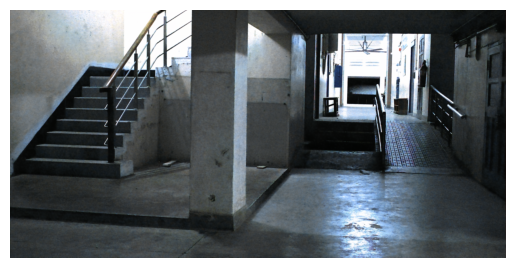

In [8]:
# For saving just the output

# For Modified Experiment 1 

for i in range(len(img_files)):
    file_name = img_files[i]
    if stereo == True:
        img = imgs[i].unsqueeze(dim = 0).float()
    else:
        img = imgs[i].float()
    # print(img.shape, 'shape of input to the model', 'from plotting cell line 8')

    # if resize:
        # img = torch.reshape(imgs[i], (1, 4, 512, 512)).float()
    # else:
        # img = torch.reshape(imgs[i], (1, 4, 1024, 2048)).float()
    with torch.no_grad():
        pred = model((img - 0.5)/0.5)*0.5+0.5
    if resize == True:
        pred = torch.reshape(pred, (3, 384, 1248))
        resizer = Resize([384, 1248])
        gt = resizer(gt)
    elif param_resize:
        pred = torch.reshape(pred, (3, 2048, 4096))
    else:
        pred = torch.reshape(pred, (3, 1024, 2048))
        resize = Resize([1024, 2048])

    pred = torch.permute(pred, (1, 2 , 0)).detach().cpu().numpy()
    plt.imshow(pred, 'gray')
    plt.axis('off')
    path = output_test_images
    file_name = file_name.split('.')[0]+'_'+str(amp)+'.png'
    print(file_name)
    plt.savefig(os.path.join(path, file_name), bbox_inches='tight', pad_inches=0)
    # image = Image.fromarray(pred)
    # image.save(os.path.join(path, file_name), format='PNG')
    # pred = cv2.convertScaleAbs(pred)
    # cv2.imwrite(os.path.join(path, file_name), pred)


In [ ]:
for i in range(len(img_files)):
    file_name = img_files[i]
    plt.figure(figsize=(20,12))
    plt.subplot(2, 2, 1)
    gt = out_imgs[i]
    gt = torch.reshape(gt, (3, 2048, 4096))
    
    img = imgs[i].unsqueeze(dim = 0).float()
    # print(img.shape, 'shape of input to the model', 'from plotting cell line 8')
    resizer = Resize([384, 1248])
    gt = resizer(gt)
    # if resize:
        # img = torch.reshape(imgs[i], (1, 4, 512, 512)).float()
    # else:
        # img = torch.reshape(imgs[i], (1, 4, 1024, 2048)).float()
    with torch.no_grad():
        pred = model((img - 0.5)/0.5)*0.5+0.5
    pred = torch.reshape(pred, (3, 384, 1248))
    # PSNR Should be calculated here
    temp = psnr(pred.cpu(), gt).item()
    print(temp)
    psnr_arr.append(temp)
    


    
    gt = torch.permute(gt, (1, 2 , 0)).detach().cpu().numpy()
    gt = gt[:, :, [2,1,0]]
    plt.title('Ground Truth {}'.format(file_name) )
    plt.imshow(gt, 'gray')
    plt.axis('off')

    plt.subplot(2,2,2)
    
    


    pred = torch.permute(pred, (1, 2 , 0)).detach().cpu().numpy()
    plt.title('Output')
    plt.imshow(pred, 'gray')
    plt.axis('off')

    ssim_arr.append(ssim(pred, gt.astype(np.float32()), channel_axis=2))
    plt.subplot(2,2,3)
    img = img[:4, :, :]
    g1 = img[:, 1, :, :]
    g2 = img[:, 2, :, :]
    g = (g1 + g2)/2
    r = img[:, 0, :, :]
    b = img[:, 3, :, :]
    inp = torch.stack((r,g,b)).squeeze().permute((1,2,0)).detach().cpu().numpy()
    plt.title('Amplified Input Image')
    plt.imshow(inp, 'gray')



    plt.subplot(2, 2, 4)
    plt.title('Difference Between Output and Input')
    plt.imshow(abs(gt - pred), 'gray')
    plt.axis('off')


    plt.subplots_adjust(wspace =0.01, hspace = 0.1)
    path ='/home/gpu/girish/enhancement/results'
    plt.savefig(os.path.join(path, file_name), )
    plt.show()
print(np.mean(psnr_arr))
print(np.mean(ssim_arr))

In [ ]:

for i in range(len(files)):
    file_name = files[i]
    plt.figure(figsize=(20,12))
    plt.subplot(2, 2, 1)
    gt = out_imgs[i]
    gt = torch.reshape(gt, (3, 2048, 4096))
    resizer = Resize([1024, 2048])
    gt = resizer(gt)
    if resize:
        img = torch.reshape(imgs[i], (1, 4, 512, 512)).float()
    else:
        img = torch.reshape(imgs[i], (1, 4, 1024, 2048)).float()
    with torch.no_grad():
        pred = model((img - 0.5)/0.5)*0.5+0.5
    pred = torch.reshape(pred, (3, 1024, 2048))
    # PSNR Should be calculated here
    temp = psnr(pred.cpu(), gt).item()
    print(temp)
    psnr_arr.append(temp)
    


    
    gt = torch.permute(gt, (1, 2 , 0)).detach().cpu().numpy()
    gt = gt[:, :, [2,1,0]]
    plt.title('Ground Truth {}'.format(file_name) )
    plt.imshow(gt, 'gray')
    plt.axis('off')

    plt.subplot(2,2,2)
    
    


    pred = torch.permute(pred, (1, 2 , 0)).detach().cpu().numpy()
    plt.title('Output')
    plt.imshow(pred, 'gray')
    plt.axis('off')

    ssim_arr.append(ssim(pred, gt.astype(np.float32()), channel_axis=2))
    plt.subplot(2,2,3)
    g1 = img[:, 1, :, :]
    g2 = img[:, 2, :, :]
    g = (g1 + g2)/2
    r = img[:, 0, :, :]
    b = img[:, 3, :, :]
    inp = torch.stack((r,g,b)).squeeze().permute((1,2,0)).detach().cpu().numpy()
    plt.title('Amplified Input Image')
    plt.imshow(inp, 'gray')



    plt.subplot(2, 2, 4)
    plt.title('Difference Between Output and Input')
    plt.imshow(abs(gt - pred), 'gray')
    plt.axis('off')


    plt.subplots_adjust(wspace =0.01, hspace = 0.1)
    path ='/home/gpu/girish/enhancement/results'
    plt.savefig(os.path.join(path, file_name), )
    plt.show()


In [ ]:
len(psnr_arr)

In [ ]:
# #predict
# results, psnrs, ssims = [], [], []
# for i, img in enumerate(imgs):
#     # pred_patches = []
#     # print(img.shape)
#     # for patch in img:
#     #     pred = model((patch.unsqueeze(0).float()-0.5)/0.5)
#     #     pred_patches.append((pred*0.5+0.5).clamp_(0,1).detach().cpu())
#     # pred = torch.vstack(pred_patches)
#     # psnrs.append(psnr(pred, out_imgs[i][:,:3,:,:]).item())
#     # result = unpatchify(pred.permute(0,2,3,1).reshape(pxs[0],pys[0],1,512,512,3).detach().numpy(), (h_s[0],w_s[0],3))
#     # results.append(result)
#     img = torch.reshape(img, (1, 4, 512, 512))
#     # plt.imshow(img)
#     # quit()
#     img = img.float()
#     # print(img)
#     pred = model(img)
#     # print(pred)
#     pred = torch.reshape(pred, (3, 512, 512))
#     pred = torch.permute(pred, (1, 2 , 0))
#     # print(pred.shape)
#     # pred = pred *50
#     # cv2.imwrite("/home/gpu/girish/enhancement/dummy/1.png",pred)
#     plt.imshow(pred.detach().cpu().numpy(), 'gray')
#     plt.show()
#     if i == 10: 
#         break

    

In [ ]:
# #predict
# results, psnrs, ssims = [], [], []
# for i, img in enumerate(out_imgs):
#     # pred_patches = []
#     # print(img.shape)
#     # for patch in img:
#     #     pred = model((patch.unsqueeze(0).float()-0.5)/0.5)
#     #     pred_patches.append((pred*0.5+0.5).clamp_(0,1).detach().cpu())
#     # pred = torch.vstack(pred_patches)
#     # psnrs.append(psnr(pred, out_imgs[i][:,:3,:,:]).item())
#     # result = unpatchify(pred.permute(0,2,3,1).reshape(pxs[0],pys[0],1,512,512,3).detach().numpy(), (h_s[0],w_s[0],3))
#     # results.append(result)
#     # img = torch.reshape(img, (1, 4, 512, 512))
#     # plt.imshow(img)
#     # quit()
#     # img = img.float()
#     # pred = model(img)
#     pred = img
#     pred = torch.reshape(pred, (3, 512, 512))
#     pred = torch.permute(pred, (1, 2 , 0))
#     print(pred.shape)
#     plt.imshow(pred.detach().cpu().numpy(), 'gray')
#     plt.show()
#     if i == 10: 
#         break

    